In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
img = np.array(Image.open('src/клоун.png'))

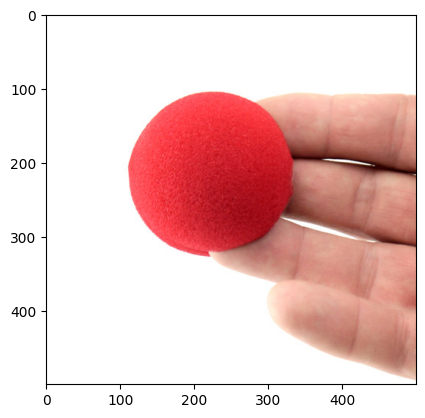

In [16]:
plt.imshow(img)

In [3]:
def normalize_rgb(rgb_image: np.ndarray):
    norm_rgb = rgb_image.astype(np.float64) / 255.0
    return np.clip(norm_rgb, 0.0, 1.0)

def linearize_srgb(srgb):
    threshold = 0.04045
    linear = np.where(
        srgb <= threshold,
        srgb / 12.92,
        ((srgb + 0.055) / 1.055) ** 2.4
    )
    return linear

def rgb_to_xyz(linear_rgb: np.ndarray):
    transition_matrix = np.array([
        [0.4124564, 0.3575761, 0.1804375],
        [0.2126729, 0.7151522, 0.0721750],
        [0.0193339, 0.1191920, 0.9503041]
    ])
    h, w, _ = linear_rgb.shape
    rgb_flat = linear_rgb.reshape(-1, 3)
    xyz_flat = rgb_flat @ transition_matrix.T
    xyz = xyz_flat.reshape(h, w, 3)
    return xyz

def normalize_xyz_to_white_point(xyz):
    Xn, Yn, Zn = 95.047, 100.0, 108.883
    x = xyz[:, :, 0] / Xn
    y = xyz[:, :, 1] / Yn
    z = xyz[:, :, 2] / Zn
    return x, y, z 

def xyz_to_lab(x, y, z):
    delta = 6.0 / 29.0
    delta3 = delta ** 3

    def func(t):
        return np.where(t > delta3, np.cbrt(t), t / (3 * delta**2) + 4/29)
    
    fx = func(x)
    fy = func(y)
    fz = func(z)

    L = 116*fy - 16
    a = 500*(fx - fy)
    b = 200*(fy - fz)

    lab = np.stack([L, a, b], axis=-1)
    return lab

def rgb_to_lab(rgb_image):
    
    rgb_norm = normalize_rgb(rgb_image)

    rgb_linear = linearize_srgb(rgb_norm)

    xyz = rgb_to_xyz(rgb_linear)

    x, y, z = normalize_xyz_to_white_point(xyz)

    lab = xyz_to_lab(x, y, z)

    return lab

In [4]:
image_lab = rgb_to_lab(img)

In [5]:
mean_L, mean_a, mean_b = np.mean(image_lab, axis=(0, 1))

In [6]:
diff = image_lab.astype(np.float32) - np.array([mean_L, mean_a, mean_b])
saliency_map = np.sqrt(np.sum(diff**2, axis=2))

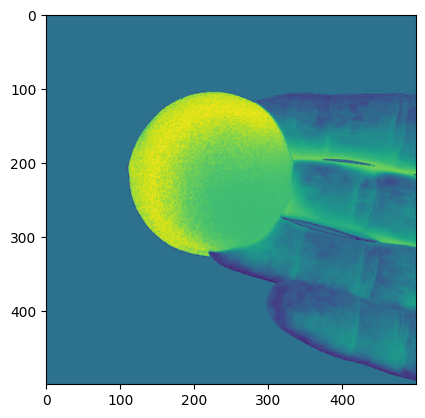

In [7]:
plt.imshow(saliency_map)

In [8]:
max_val = max(max(row) for row in saliency_map)
threshold = max_val * 0.6

In [9]:
height, width = saliency_map.shape

In [10]:
binary_mask = [[1 if saliency_map[i][j] >= threshold else 0
                for j in range(width)]
               for i in range(height)]

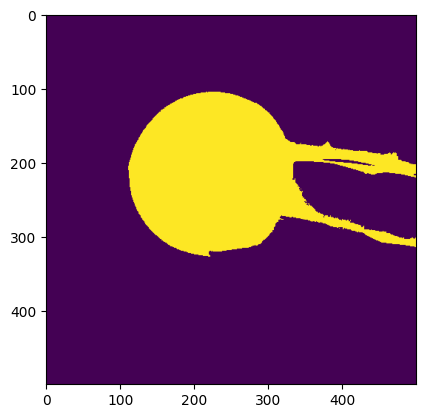

In [11]:
plt.imshow(binary_mask)

In [12]:
def flood_fill_from(start_i, start_j, binary_mask):
    height = len(binary_mask)
    width = len(binary_mask[0])
    visited = [[False for _ in range(width)] for _ in range(height)]
    component = set()
    stack = [(start_i, start_j)]

    while stack:
        i, j = stack.pop()
        if i < 0 or i >= height or j < 0 or j >= width:
            continue
        if visited[i][j] or binary_mask[i][j] == 0:
            continue
        visited[i][j] = True
        component.add((i, j))
        # 4-связность
        stack.extend([(i-1, j), (i+1, j), (i, j-1), (i, j+1)])

    return component

In [13]:
max_i, max_j = 0, 0
for i in range(height):
    for j in range(width):
        if saliency_map[i][j] > saliency_map[max_i][max_j]:
            max_i, max_j = i, j

main_component = flood_fill_from(max_i, max_j, binary_mask)

In [17]:
result_image = [[(img[i][j] if (i, j) in main_component else (255, 255, 255))
                 for j in range(width)]
                for i in range(height)]

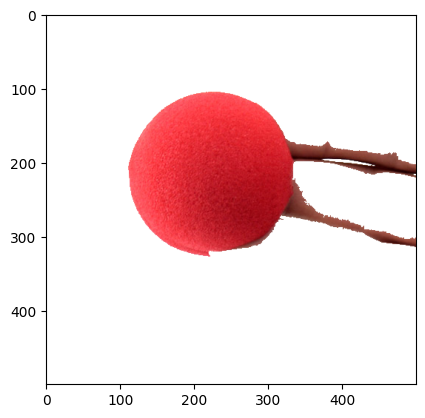

In [18]:
plt.imshow(result_image)